<h1 style="text-align:center; font-size: 20px"> CSCI E-89 Deep Learning, Fall  2022</h1>
<h1 style="text-align:center; font-size: 20px"> Harvard University Extension School</h1>
<h1 style="text-align:center; font-size: 20px"> Prof. Zoran B. Djordjević</h1>

![Harvard logo](image/harvard1.png)

<h4 style='text-align: center ;font-size: 20px'> Final Project </h4>

<h4 style='text-align: center ;font-size: 20px'> Fake News Detection </h4>

<h2 style='text-align: center;font-size: 20px'> ARZU ISIK TOPBAS </h2>

### Problem Statement

Fake News is pervasive nowadays and is too simple to broadcast via social media and challenging for us to recognize. It is almost impossible to prevent the spread of fake news. It is vital to recognize and differentiate between false and accurate news.

In this project, my goal is to build a model that can distinguish fake news with as much accuracy as possible by utilizing deep learning tools.

Although there are many other unstructured formats of news content available online (including documents, videos, and audio), I focus on news in text format.


#### Installations

In [ ]:
! pip install pandas
! pip install numpy
! pip install matplotlib
! pip install seaborn
! pip install keras
! pip install nltk
! pip install tabulate

#### Import libraries

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
import nltk
import re 

%matplotlib inline

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, plot_confusion_matrix

from keras.preprocessing import text, sequence

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM, Dropout, Bidirectional

from tensorflow.keras.preprocessing.sequence import pad_sequences


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stopwords = stopwords.words('english')

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# check versions
import pkg_resources
import dataframe_image as dfi
import pandas as pd

packages = [
    'keras', 'wordcloud', 'pandas', 'numpy', 'seaborn','matplotlib', 'ipython','jupyterlab','nltk','re','tf']
packages.sort(reverse=True)
packages_list = []

for m in pkg_resources.working_set:
    if m.project_name.lower() in packages:
        packages_list.append([m.project_name, m.version])

df = pd.DataFrame(packages_list,columns=["package", "version"]).set_index("package").transpose()
pack = [["tensorflow",'2.9.2'],['re', '2.2.1']]

df2 = pd.DataFrame(pack,columns=["package", "version"]).set_index("package").transpose()
df_version = df.join(df2)
df_version
#dfi.export(df_version, 'image/versions.png') -- save as an image

package,ipython,nltk,jupyterlab,matplotlib,keras,numpy,wordcloud,pandas,seaborn,tensorflow,re
version,8.4.0,3.7,3.4.6,3.2.2,2.9.0,1.23.3,1.8.2.2,1.4.4,0.12.0,2.9.2,2.2.1


### Load Data

#### Read data

Data obtained from - [ISOT Fake News Dataset](https://www.uvic.ca/ecs/ece/isot/datasets/fake-news/index.php?utm_medium=redirect&utm_source=/engineering/ece/isot/datasets/fake-news/index.php&utm_campaign=redirect-usage)

The fake news data and real news data is separated into two different datasets, each with approximately 20,000 articles. The dataset includes a variety of articles on various subjects, although the majority of them are about politics and international news.


Reference :
* Ahmed H, Traore I, Saad S. “Detecting opinion spams and fake news using text classification”, Journal of Security and Privacy, Volume 1, Issue 1, Wiley, January/February 2018.
* Ahmed H, Traore I, Saad S. (2017) “Detection of Online Fake News Using N-Gram Analysis and Machine Learning Techniques. In: Traore I., Woungang I., Awad A. (eds) Intelligent, Secure, and Dependable Systems in Distributed and Cloud Environments. ISDDC 2017. Lecture Notes in Computer Science, vol 10618. Springer, Cham (pp. 127-138).

In [3]:
# import datasets
df_real = pd.read_csv("data/True.csv")
df_fake = pd.read_csv("data/Fake.csv")

In [4]:
# display dataset
df_real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
# display dataset
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
# shape of dataset
print("Real news: ",df_real.shape)
print("Fake News: ", df_fake.shape)

Real news:  (21417, 4)
Fake News:  (23481, 4)


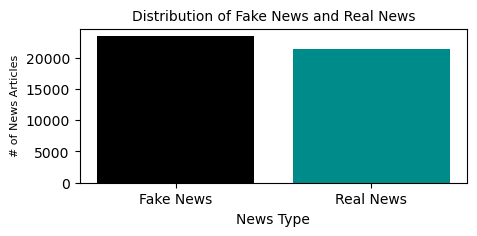

In [7]:
# show distribution of labels
plt.figure(figsize=(5, 2))
plt.bar('Fake News', len(df_fake), color='black')
plt.bar('Real News', len(df_real), color='darkcyan')
plt.title('Distribution of Fake News and Real News',size=10)
plt.xlabel('News Type', size=10)
plt.ylabel('# of News Articles', size=8)
plt.savefig('image/distribution_of_data.png')

The dataset looks balanced

In [8]:
# assign "1" for all real news and place in the dataframe

class1 = []

for i in range(len(df_real)):
    class1.append(1)

df_real.insert(4, "label", class1, True)

In [9]:
# assign "0" for all fake news and place in the dataframe

class0 = []

for i in range(len(df_fake)):
    class0.append(0)

df_fake.insert(4, "label", class0, True)

In [10]:
# Merge fake news and real news into 1 total dataset
total = pd.concat([df_real,df_fake])
total = total.sample(frac = 1)
total.head()

,title,text,subject,date,label
15444,(VIDEO) DEM PRESIDENTIAL CANDIDATE GIVES UNBEL...,Can anyone be at all serious about a President...,politics,"Jul 21, 2015",0
9982,"Grassley, Garland reprise 1990s judicial confi...",WASHINGTON (Reuters) - Chuck Grassley and Merr...,politicsNews,"April 11, 2016",1
11915,LT GEN MCINERNEY’S Take On Trump Dossier And C...,,politics,"Jan 13, 2017",0
19171,Hurdles high for Merkel in three-way 'Jamaica'...,BERLIN (Reuters) - Germany s conservative chan...,worldnews,"September 24, 2017",1
19390,"Fearing far-right surge, Merkel tells Germans ...",BERLIN (Reuters) - Fears in Germany that vote...,worldnews,"September 21, 2017",1


### Clean Data

#### Check missing values

In [11]:
# get info
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 15444 to 5560
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [12]:
# check missing values
total.isna().any().any() # no missing value

False

#### Check duplicates

In [13]:
# count dublicates
count_title = total.title.value_counts()

len(count_title[count_title>1]) # 5629 entries have the same title.

5629

In [14]:
# drop duplicate
total = total.drop_duplicates()
len(total)

44689

In [15]:
# drop rows with same title and text 
total = total.drop_duplicates(['title', 'text'])
len(total)

39105

In [16]:
# drop rows with exact same text
total = total.drop_duplicates(['text'])
len(total)

38646

#### Investigate subject

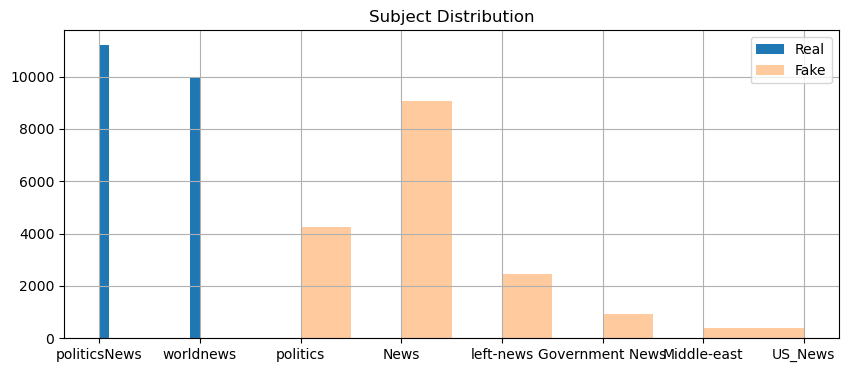

In [17]:
# plot Subject Distribution
plt.figure(figsize = (10,4))
total[total['label'] == 1]['subject'].hist(label='Real')
total[total['label'] == 0]['subject'].hist(alpha=0.4, label='Fake')
plt.title('Subject Distribution')
plt.legend()
plt.savefig('image/subject_dist.png')

### Preprocessing

In [18]:
# create a copy
df_clean = total.copy()

# merge text and title
df_clean['text'] = df_clean['text'] + " " + df_clean['title']

# drop unnecessary cols
df_clean = df_clean.drop(['title', 'subject', 'date'], axis = 1)

df_clean.head()

,text,label
15444,Can anyone be at all serious about a President...,0
9982,WASHINGTON (Reuters) - Chuck Grassley and Merr...,1
11915,LT GEN MCINERNEY’S Take On Trump Dossier And...,0
19171,BERLIN (Reuters) - Germany s conservative chan...,1
19390,BERLIN (Reuters) - Fears in Germany that vote...,1


In [19]:
# remove lower case, get rid of extra spaces, and url links.
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        
        normalized.append(i)
        
    return normalized

In [20]:
df_clean['text'] = normalize(df_clean['text'])

In [21]:
# remove stopwords & apply lemmatize
def remove_stopwords(text):
    words = []
    for word in text.split():
        if word.strip().lower() and len(word.strip().lower()) > 3 not in stopwords:
            words.append(lemmatizer.lemmatize(word))
    cleantext = " ".join(words)
    return cleantext

In [22]:
# apply function
df_clean['text'] = df_clean['text'].apply(remove_stopwords)

In [23]:
# save cleaned data .csv
df_clean.to_csv('data/data_clean.csv')

In [24]:
df_clean.shape

(38646, 2)

### Word Clouds

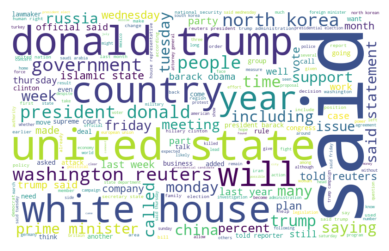

In [25]:
# wordcloud for real data 
wordcloud_real = WordCloud(background_color='white',
    width= 800, height= 500,
    max_font_size = 180).generate(" ".join(df_clean[df_clean.label == 1].text))

plt.figure(figsize=(8,3))
#plt.title(' True data ',color='gray',size = (18)) 
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis("off")
plt.savefig('image/true_cloud.png')

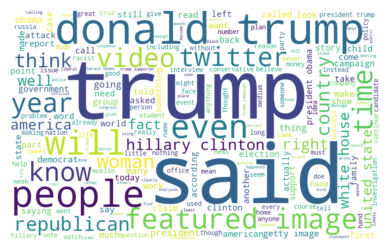

In [26]:
# wordcloud for fake data 
wordcloud_real = WordCloud(background_color='white',
    width= 800, height= 500,
    max_font_size = 180).generate(" ".join(df_clean[df_clean.label == 0].text))

plt.figure(figsize=(8,3))
#plt.title(' Fake data ',color='gray',size = (18)) 
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis("off")
plt.savefig('image/fake_cloud.png')

#### Analysing N-grams

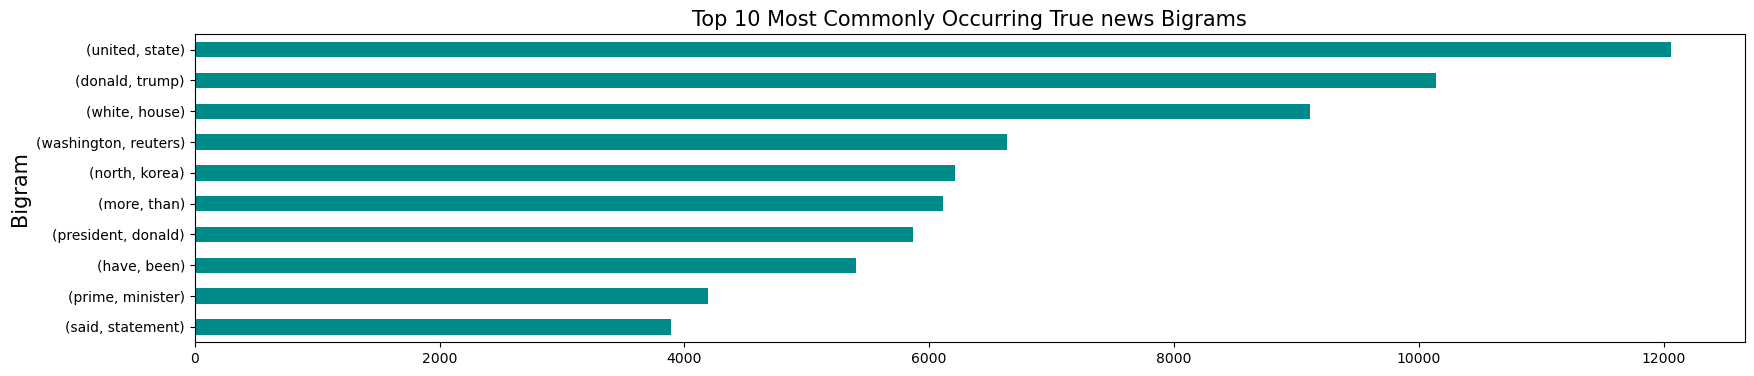

In [27]:
# Two-word Combination
input_text_real = " ".join(df_clean[df_clean.label == 1].text)
true_b = (pd.Series(nltk.ngrams(input_text_real.split(), 2)).value_counts())[:10]
true_b.sort_values().plot.barh(color='darkcyan', width=.5, figsize=(20, 4))
plt.title('Top 10 Most Commonly Occurring True news Bigrams', size=15)
plt.ylabel("Bigram", size=15)
plt.savefig('image/truebigrams.png')

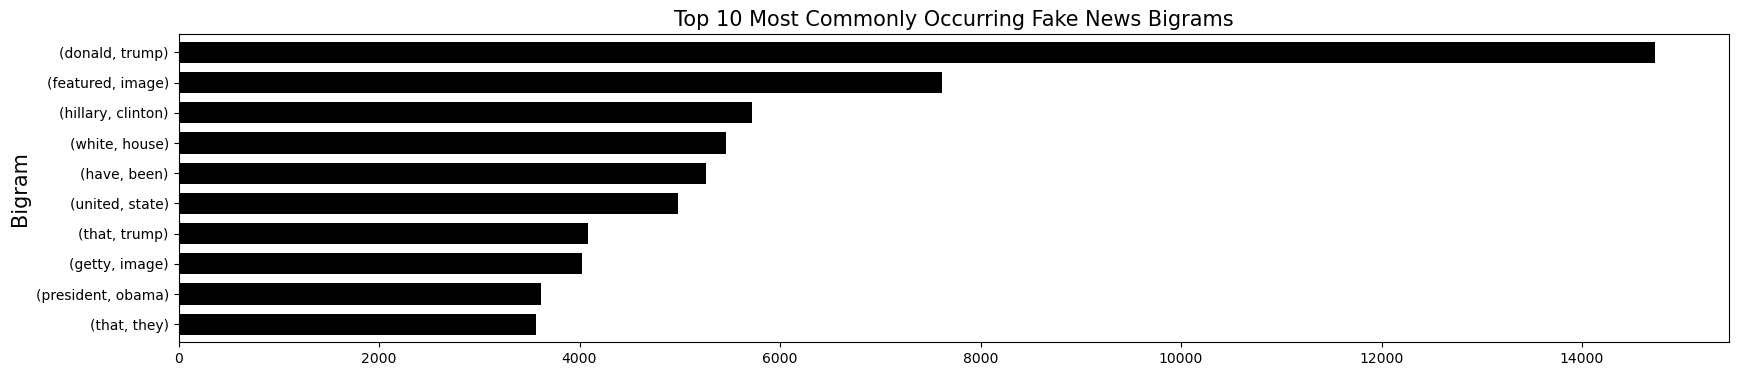

In [28]:
# Two-word Combination 
input_text_fake = " ".join(df_clean[df_clean.label == 0].text)
fake_b = (pd.Series(nltk.ngrams(input_text_fake.split(), 2)).value_counts())[:10]
fake_b.sort_values().plot.barh(color='black', width=.7, figsize=(20, 4))
plt.title('Top 10 Most Commonly Occurring Fake News Bigrams', size=15)
plt.ylabel("Bigram", size=15)
plt.savefig('image/fakebigrams.png')

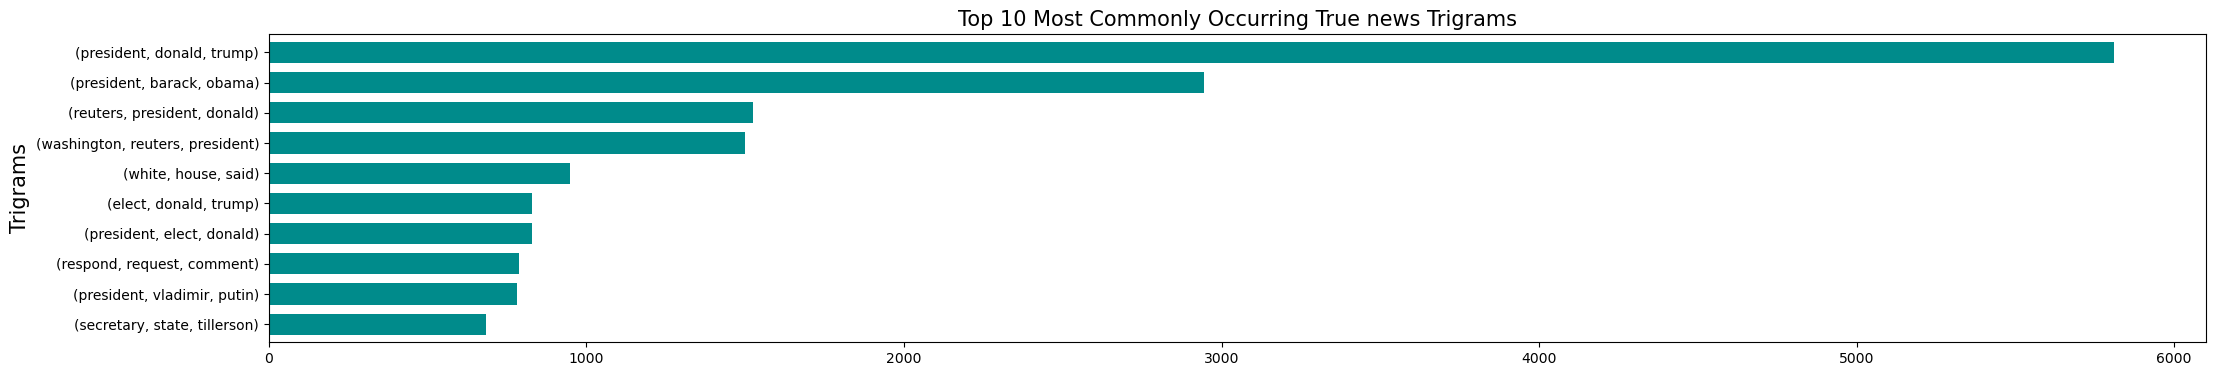

In [29]:
# Three-word Combination 
true_b = (pd.Series(nltk.ngrams(input_text_real.split(), 3)).value_counts())[:10]
true_b.sort_values().plot.barh(color='darkcyan', width=.7, figsize=(25, 4))
plt.title('Top 10 Most Commonly Occurring True news Trigrams', size=15)
plt.ylabel("Trigrams", size=15)
plt.savefig('image/true_trigrams.png')

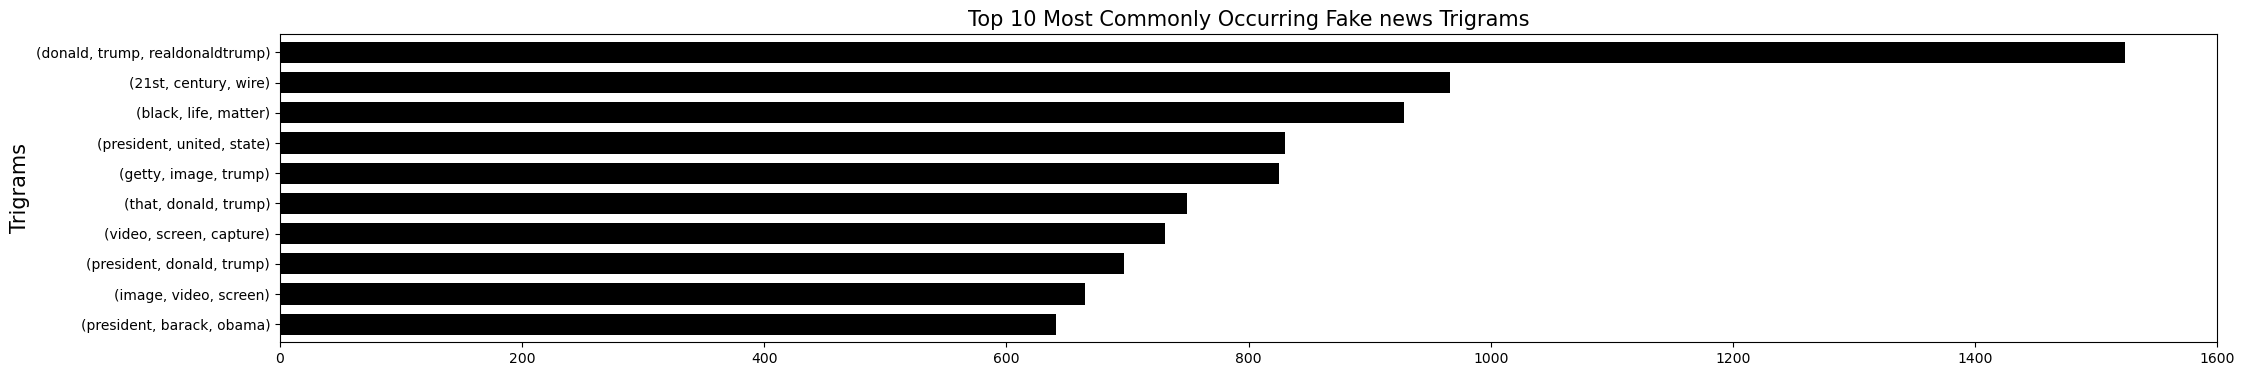

In [30]:
# Three-word Combination 
fake_b = (pd.Series(nltk.ngrams(input_text_fake.split(), 3)).value_counts())[:10]
fake_b.sort_values().plot.barh(color='black', width=.7, figsize=(25, 4))
plt.title('Top 10 Most Commonly Occurring Fake news Trigrams', size=15)
plt.ylabel("Trigrams", size=15)
plt.savefig('image/false_trigrams.png')

### Modelling

#### Train valid test split

In [31]:
# Train-Test split
train_df, test_df, y_train, y_test = train_test_split(df_clean['text'], df_clean['label'], 
                                                                    random_state=1023, 
                                                                    shuffle = True,
                                                                    test_size=0.2,
                                                                    stratify=df_clean['label'])

In [32]:
# Train-Valid split

train_df, val_df, y_train, y_val = train_test_split(train_df, y_train, 
                                                                random_state=1023,
                                                                test_size=0.20,
                                                   stratify=y_train)

In [33]:
print('trainset size:', train_df.shape)
print('valset size:', val_df.shape)
print('testset size:', test_df.shape)

trainset size: (24732,)
valset size: (6184,)
testset size: (7730,)


I combine the dataset and split it into train, validation, and test sets with shuffling at the ratio of 64%:16%:20%. 


#### Tokenizing

In [34]:
# set max_feat and maxlen
max_features = 10000
maxlen = 300

In [35]:
# create a tokenizer to tokenize the words
tokenizer = text.Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(train_df)

# create sequences of tokenized words
X_train = tokenizer.texts_to_sequences(train_df)
X_val = tokenizer.texts_to_sequences(val_df)
X_test = tokenizer.texts_to_sequences(test_df)

# add padding
X_train = pad_sequences(X_train,maxlen = maxlen, padding = 'post', truncating = 'post')
X_val = pad_sequences(X_val,maxlen = maxlen, padding = 'post', truncating = 'post')
X_test = pad_sequences(X_test,maxlen = maxlen, padding = 'post', truncating = 'post')


In [36]:
#### GloVe embeddings

Global vectors -GloVe- are an unsupervised learning method that creates word vector representations. GloVe is a word vector technic that training is based on a corpus of global word-to-word co-occurrence statistics, resulting in a meaningful linear vector space. I use glove Twitter data for word embedding.

In [37]:
# get pre-trained word vectors
twitter_file = 'data/glove.twitter.27B.100d.txt' 

In [38]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')

# create dictionary
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(twitter_file))

In [39]:
# get embeddings
embeddings = np.stack(embeddings_index.values())

embeddings_mean = embeddings.mean()

embeddings_std = embeddings.std()

word_index = tokenizer.word_index

numwords = min(max_features, len(word_index))

In [40]:
# size of embeddings
embeddings_size = embeddings.shape[1]

# create embeddings matrix
embedding_matrix = np.random.normal(embeddings_mean, embeddings_std, (numwords, embeddings_size))

for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

#### Training the model

In [41]:
# set parameters
batch_size = 256
epochs = 10
embeddingsize = 100

In [42]:
# create model
model = Sequential()

# add embedding layer (non-trainable)
model.add(Embedding(max_features, 
                    output_dim = embeddingsize,
                    weights = [embedding_matrix],
                    input_length = maxlen,
                    trainable = False))

model.add(LSTM(units = 128,return_sequences = True))
model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(units = 128)))
model.add(Dropout(0.3))

model.add(Dense(units = 32, activation = 'relu'))

model.add(Dense(units = 1, activation = 'sigmoid'))

In [43]:

model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.01), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 300, 128)          117248    
                                                                 
 dropout (Dropout)           (None, 300, 128)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 32)                8224      
                                                        

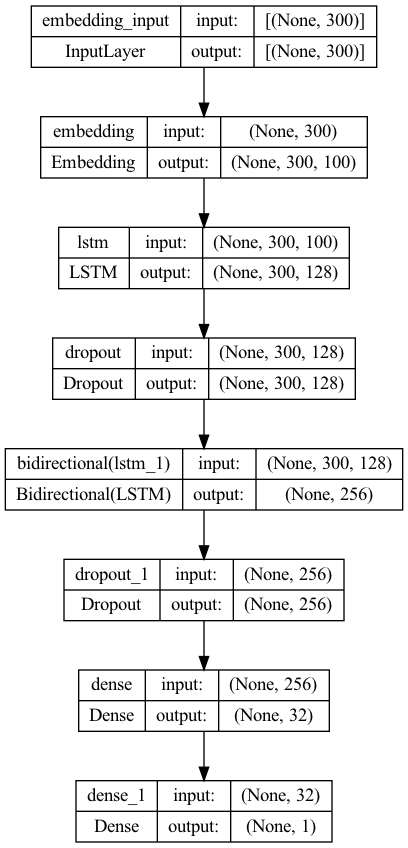

In [45]:
keras.utils.plot_model(model, 'image/my_funct_model.png', show_shapes=True)

In [46]:

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(X_train, 
                    y_train, 
                    batch_size = batch_size , 
                    validation_data = (X_val, y_val) , 
                    epochs = epochs , 
                    callbacks = early_stop)

Epoch 1/10


2022-12-14 15:35:42.383461: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


97/97 [==============================] - 251s 3s/step - loss: 0.0982 - accuracy: 0.9675 - val_loss: 0.0171 - val_accuracy: 0.9945
Epoch 2/10
97/97 [==============================] - 252s 3s/step - loss: 0.0121 - accuracy: 0.9968 - val_loss: 0.0047 - val_accuracy: 0.9987
Epoch 3/10
97/97 [==============================] - 247s 3s/step - loss: 0.0074 - accuracy: 0.9985 - val_loss: 0.0046 - val_accuracy: 0.9989
Epoch 4/10
97/97 [==============================] - 250s 3s/step - loss: 0.0051 - accuracy: 0.9989 - val_loss: 0.0063 - val_accuracy: 0.9987
Epoch 5/10
97/97 [==============================] - 244s 3s/step - loss: 0.0040 - accuracy: 0.9991 - val_loss: 0.0057 - val_accuracy: 0.9981


#### Model evaluation

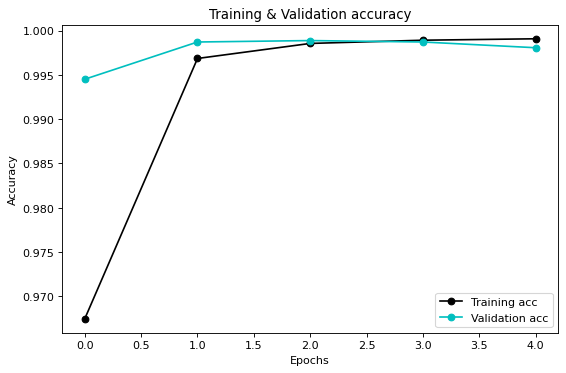

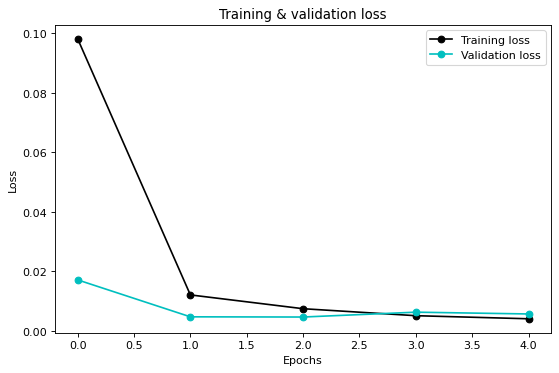

In [47]:
# plot accuracy & loss

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(8, 5), dpi=80)
plt.plot(epochs, acc, 'ko-', label='Training acc')
plt.plot(epochs, val_acc, 'co-', label='Validation acc')
plt.title('Training & Validation accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.savefig('image/acc.png') 

plt.figure(figsize=(8, 5), dpi=80)
plt.plot(epochs, loss, 'ko-', label='Training loss')
plt.plot(epochs, val_loss, 'co-', label='Validation loss')
plt.title('Training & validation loss')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

plt.savefig('image/loss.png')

We see that the accuracy score remains roughly constant after 1 epoch, signifying that convergence has been achieved. We also note the similarity in results between train and test sets, signifying no overfitting.
Similar to the previous visualising for accuracy, we note that loss stabilizes after the first epoch and is similar for both train and test sets.

In [48]:
# evaluate the model fit with linear dummy data

model_loss, model_accuracy = model.evaluate(X_test, y_test)

242/242 [==============================] - 48s 198ms/step - loss: 0.0074 - accuracy: 0.9987


In [49]:
print(f"Loss: {round(model_loss,4)}, Accuracy: {round(model_accuracy,4)}")

Loss: 0.0074, Accuracy: 0.9987


In [50]:
# make prediction

pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

242/242 [==============================] - 49s 201ms/step


In [51]:
pred = model.predict(X_test)

242/242 [==============================] - 48s 200ms/step


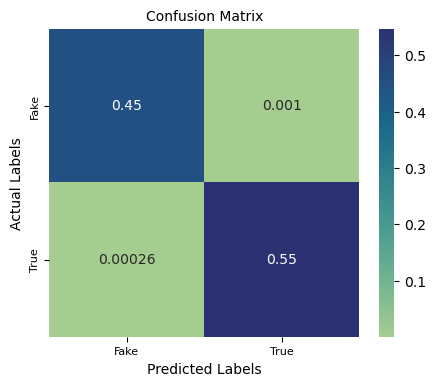

In [52]:
# Confusion matrix

matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(5, 4))
ax= plt.subplot()

sns.heatmap(matrix, cmap= "crest",annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=10)
ax.set_ylabel('Actual Labels', size=10)
ax.set_title('Confusion Matrix', size=10) 
ax.xaxis.set_ticklabels(['Fake','True'], size=8)
ax.yaxis.set_ticklabels(['Fake','True'], size=8)
plt.savefig("image/Confusion_matrix")

In [53]:
print(classification_report(y_test, binary_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3491
           1       1.00      1.00      1.00      4239

    accuracy                           1.00      7730
   macro avg       1.00      1.00      1.00      7730
weighted avg       1.00      1.00      1.00      7730



In [54]:
# get confusion matrix
conf_matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
conf_matrix

array([[4.51358344e-01, 1.03492885e-03],
       [2.58732212e-04, 5.47347995e-01]])

\begin{equation}
Accuracy = \frac{TP+TN}{TP+TN+FP+FN}
\end{equation}

\begin{equation}
Precision  = \frac{TP}{TP+FP}
\end{equation}

\begin{equation}
Recall = \frac{TP}{TP+FN}
\end{equation}

\begin{equation}
F1-Score = \frac{2*Precision*Recall}{Precision+Recall}
\end{equation}

In [55]:
# get accuracy
from sklearn.metrics import accuracy_score

print('Accuracy : %.4f' % accuracy_score(y_test, binary_predictions))

Accuracy : 0.9987


In [56]:
# get precision
from sklearn.metrics import precision_score

print('Precision: %.4f' % precision_score(y_test, binary_predictions))

Precision: 0.9995


In [57]:
# get recall
from sklearn.metrics import recall_score

print('Recall: %.4f' % recall_score(y_test, binary_predictions))

Recall: 0.9981


In [58]:
# get F1-score
from sklearn.metrics import f1_score

print('F1-score : %.4f' % f1_score(y_test, binary_predictions))

F1-score : 0.9988


In [59]:
# import module
from tabulate import tabulate
 
# assign data
mydata = [
    ["Accuracy", round(accuracy_score(y_test, binary_predictions),4)],
    ["Precision", round(precision_score(y_test, binary_predictions),4)],
    ["Recall", round(recall_score(y_test, binary_predictions),4)],
      ["F1-score", round(f1_score(y_test, binary_predictions),4)]
]
 
# create header
head = ["Metrics", "Results"]
 
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))

+-----------+-----------+
| Metrics   |   Results |
+===========+===========+
| Accuracy  |    0.9987 |
+-----------+-----------+
| Precision |    0.9995 |
+-----------+-----------+
| Recall    |    0.9981 |
+-----------+-----------+
| F1-score  |    0.9988 |
+-----------+-----------+


### Conclusion

The model performes well on Test data.


#### Future work

* Gather more data

Our current data set consists of mainly political news. We can get new information from other sources and train the model on a wider range of topics.

* Explore transfer learning tools

We can look at other transfer learning tools and advances in NLP to continue building and iterating on our model.

In [60]:
!jupyter nbconvert FakeNewsDetection_IsikTopbasArzu.ipynb --to html

[NbConvertApp] Converting notebook FakeNewsDetection_IsikTopbasArzu.ipynb to html
[NbConvertApp] Writing 1511412 bytes to FakeNewsDetection_IsikTopbasArzu.html
